## Geneshot Associated Gene Drug-Set Library
### Drug-set labels: Genes
#### ALL DATABASES ACCESSED 03/2020
##### Author : Eryk Kropiwnicki | eryk.kropiwnicki@icahn.mssm.edu

In [1]:
import csv
import time 
import requests
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir('../../scripts')
from export_script import *
from gene_resolver import *
os.chdir('../notebooks/Geneshot')

#### Input file : drug_metadata.tsv (generated from Drug Metadata Aggregation.ipynb)

In [3]:
# Import all small molecules #
df = pd.read_csv('../../metadata/drugmonizome_metadata.tsv', sep = '\t')
df['Common name'] = df['Common name'].str.lower()

In [4]:
df.head()

,DrugBank ID,Accession Numbers,Common name,CAS,UNII,Synonyms,InChI Key,Canonical_SMILES
0,DB00006,BIOD00076 | BTD00076 | DB02351 | EXPT03302,bivalirudin,128270-60-0,TN9BEX005G,Bivalirudin | Bivalirudina | Bivalirudinum,OIRCOABEOLEUMC-GEJPAHFPSA-N,CCC(C)C(C(=O)N1CCCC1C(=O)NC(CCC(=O)O)C(=O)NC(C...
1,DB00007,BIOD00009 | BTD00009,leuprolide,53714-56-0,EFY6W0M8TG,Leuprorelin | Leuprorelina | Leuproreline | Le...,GFIJNRVAKGFPGQ-LIJARHBVSA-N,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...
2,DB00014,BIOD00113 | BTD00113,goserelin,65807-02-5,0F65R8P09N,Goserelin | Goserelina,BLCLNMBMMGCOAS-URPVMXJPSA-N,CC(C)CC(C(=O)NC(CCCN=C(N)N)C(=O)N1CCCC1C(=O)NN...
3,DB00027,BIOD00036 | BTD00036,gramicidin d,1405-97-6,5IE62321P4,Bacillus brevis gramicidin D | Gramicidin | Gr...,NDAYQJDHGXTBJL-MWWSRJDJSA-N,CC(C)CC(C(=O)NC(C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)...
4,DB00035,BIOD00061 | BIOD00112 | BTD00061 | BTD00112,desmopressin,16679-58-6,ENR1LLB0FP,1-(3-mercaptopropionic acid)-8-D-arginine-vaso...,NFLWUMRGJYTJIN-PNIOQBSNSA-N,C1CC(N(C1)C(=O)C2CSSCCC(=O)NC(C(=O)NC(C(=O)NC(...


In [5]:
smallmolecules = df['Common name'].tolist()

In [6]:
len(smallmolecules)

14579

In [7]:
# Creating inchi lookup for matching drug names later
inchi_lookup = df.set_index('Common name').to_dict()['InChI Key']

### Querying Small Molecule Names Through Geneshot
#### PLATFORM : https://amp.pharm.mssm.edu/geneshot

In [ ]:
# Queries a drug list through the Geneshot API to retrieve gene terms associated with each drug
# and saves the results as a json in the input folder

feeds = []

for entry in smallmolecules:
    response = requests.get('https://amp.pharm.mssm.edu/geneshot/api/search/auto/' + entry)
    try:
        response.json()
        data = response.json()
    except ValueError:
        pass
    feeds.append(data)
    time.sleep(0.5)
    
with open('input/geneset_autorif.json','a') as outfile:
    json.dump(feeds,outfile,indent = 4)        
    outfile.close()

### Creating geneset library from drug-gene associations collected from Geneshot

In [8]:
# Creating a dictionary where small molecules are terms and genes are set members #
df_counts = pd.DataFrame()
gene_list = []
compound_list = []
mention_score = []

with open ('input/geneset_autorif.json') as data_file:
    data = json.load(data_file)

for item in data:
    genes = item["gene_count"]
    if len(genes) > 1:
        compound = inchi_lookup[(item["search_term"]).lower()] # get InChIKey for each drug name
        for gene in genes:
            gene_list.append(gene)
            compound_list.append(compound)
            mention_score.append(float(genes[gene][0])*float(genes[gene][1])) # total mentions * frequency in literature

df_counts['Compound_name'] = compound_list
df_counts['Gene_name'] = gene_list
df_counts['Mention_score'] = mention_score

In [9]:
len(df_counts)

1555343

In [10]:
# Filter each small molecule and its top 200 associated genes by mention score
df_counts = df_counts.sort_values(by = ['Compound_name', 'Mention_score'], ascending = False)\
    .groupby('Compound_name')\
    .head(200)

In [11]:
df_counts.head()

,Compound_name,Gene_name,Mention_score
187407,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,SLC47A1,0.108434
187409,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,HNMT,0.091837
187405,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,HDC,0.040712
187473,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,SLC44A1,0.033333
187445,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,HVCN1,0.029412


### Retrieve approved symbol for each unique gene returned in the results

In [12]:
unique_genes = list(set(df_counts['Gene_name'].tolist()))

In [13]:
# Retrieve dataframe of Geneshot genes matched to approved symbols
approved_symbols = gene_resolver(unique_genes,fmt='list')

In [14]:
# Merge each approved symbol on its synonym
df_counts = df_counts.merge(approved_symbols)

In [15]:
df_counts.head()

,Compound_name,Gene_name,Mention_score,Approved Symbol
0,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,SLC47A1,0.108434,SLC47A1
1,ZROHGHOFXNOHSO-BNTLRKBRSA-L,SLC47A1,0.192771,SLC47A1
2,ZRALSGWEFCBTJO-UHFFFAOYSA-N,SLC47A1,6.939759,SLC47A1
3,ZPUCINDJVBIVPJ-LJISPDSOSA-N,SLC47A1,0.048193,SLC47A1
4,ZAIPMKNFIOOWCQ-UEKVPHQBSA-N,SLC47A1,0.012048,SLC47A1


In [16]:
# Filter each gene by top 1000 small molecule associations by mention_score
df_filtered = df_counts.sort_values(by = ['Approved Symbol', 'Mention_score'], ascending = False)\
    .groupby('Approved Symbol')\
    .head(1000)

In [17]:
genes = df_filtered['Approved Symbol'].tolist()
compounds = df_filtered['Compound_name'].tolist()

id_list = tuple(zip(compounds,genes))
genesetlibrary = defaultdict(list)
for k,v in id_list:
    genesetlibrary[k].append(v)
    
genesetlibrary = {k:list(set(v)) for k,v in genesetlibrary.items() if len(set(v)) >=5}

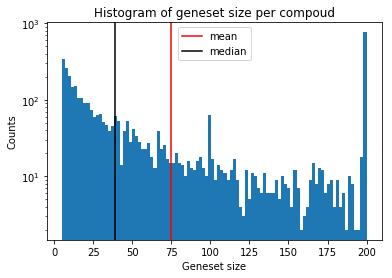

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pylab import figure, text, scatter, show

df_setsize = pd.DataFrame(columns = ['Compound','Geneset_size'])
drugs = []
geneset = []
for k,v in genesetlibrary.items():
    drugs.append(k)
    geneset.append(len(set(v)))
df_setsize['Compound'] = drugs
df_setsize['Geneset_size'] = geneset

plt.figure()
plt.hist(df_setsize['Geneset_size'].values, bins=100)
plt.xlabel('Geneset size')
plt.ylabel('Counts')
plt.title('Histogram of geneset size per compoud')
plt.yscale('log')
plt.axvline(np.mean(df_setsize['Geneset_size']), color='red', label='mean')
plt.axvline(np.median(df_setsize['Geneset_size']), color='black', label='median')
plt.legend()
plt.show()

### Creating genesetlibrary with drugs as terms

In [19]:
# Converting dictionary into GMT format #
GSL = []

for term in genesetlibrary.keys():    
    genes = genesetlibrary[term]
    line = '{0}\t\t{1}'.format(term, '\t'.join(genes))
    GSL.append(line)

GSL_out = '\n'.join(GSL)

In [ ]:
# Exporting genesetlibrary as TXT file #
dataFile = open('input/geneshot_drug_genesetlibrary.txt', 'w')
for eachitem in GSL_out:
    dataFile.write(eachitem)
dataFile.close()

### Creating drugsetlibrary from gene-drug associations collected from Geneshot

In [20]:
# Transposing the 'genelist' dictionary where genes are terms and small molecules are set members #
# Each value (gene) in the dictionary is a list, therefore we need to separate all list elements as their own term #
d = defaultdict(list)
for k,v in genesetlibrary.items():
    for gene in v:
        gene.split(',')
        d[gene].append(k)

drugsetlibrary = dict(d)

In [21]:
# Removing all terms paired with less than 5 drugs #
drugsetlibrary = {k:v for k,v in drugsetlibrary.items() if len(v)>=5}

### Library counts

In [22]:
library_counts(drugsetlibrary)

3938 unique drugs
7503 unique association terms
283625 unique associations
37.80154604824737 average drugs per term


### Exporting the drugsetlibrary in DMT format

In [23]:
os.chdir('../../data/Geneshot')

In [24]:
gmt_formatter(drugsetlibrary, 'Geneshot_associated_drugsetlibrary.gmt')